In [1]:
import pandas as pd
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from random import shuffle
import PIL
from PIL import Image
import copy
import cv2
import glob
import cv2
import os 
from os import path
from skimage.color import lab2rgb
torch.set_default_tensor_type('torch.FloatTensor')
import torch.nn as nn
from torch.nn import Linear, ReLU, MSELoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, ConvTranspose2d
from torch.optim import Adam, SGD
from math import log10, sqrt
import numpy as np
from skimage.metrics import structural_similarity
import argparse
import imutils

In [2]:
class Convnet(nn.Module):   
    def __init__(self):
        super(Convnet, self).__init__()

        self.convolution_layers = Sequential(
            Conv2d(1, 8, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(8),
            nn.ReLU(),
            Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(16),
            nn.ReLU(),
            Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            nn.ReLU(),
            Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(64),
            nn.ReLU(),
            Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.deconvolution_layers = Sequential(
            ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(64),
            nn.ReLU(),
            ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            nn.ReLU(),
            ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(16),
            nn.ReLU(),
            ConvTranspose2d(16, 8, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(8),
            nn.ReLU(),
            ConvTranspose2d(8, 2, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(2),
            nn.ReLU()
        )


    # Defining the forward pass    
    def forward(self, x):
        x = self.convolution_layers(x)
        x = self.deconvolution_layers(x)
        return x

In [3]:
model=torch.load('colorizer.pkl')

In [73]:
for param in model.parameters():
    param.requires_grad=False

# Transfer Learning Architecture 1

In [79]:
#Adding layers in convolution part and deconvolution part of the original architecture

In [74]:
model.convolution_layers[14]=Sequential(
            nn.ReLU(),
            Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(256),
            nn.ReLU(),
            Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(512),
            nn.ReLU()
        )
model.deconvolution_layers[0]=Sequential(
    ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(),
    Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(),
    ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
print(model)

Convnet(
  (convolution_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Sequential(
      (0): ReLU()
      (1): Conv2d(128, 256, k

In [5]:
#Loading data function
images = []
def load_images_from_folder(folder):
    for filename in os.listdir(folder):
        #print(filename)
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.resize(img,(128,128))
        if img is not None:
            #print('hi')
            images.append((img,filename))
    return images

In [6]:
#LAB images
images = load_images_from_folder("./Colorful")
L_images = []
ab_images= []
for img,filename in images:
    imageLAB = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    L, a, b = cv2.split(imageLAB)
    L=np.array(L,dtype=np.float32)
    L=L[np.newaxis,:,:]
    a=np.array(a,dtype=np.float32)
    b=np.array(b,dtype=np.float32)
    ab=[]
    ab.append(a)
    ab.append(b)
    ab=np.array(ab)
    ab_images.append(torch.tensor(ab))
    L_images.append(torch.tensor(L))

In [7]:
#Train & Test data
train_percentage=90
train_size=int((721/100)*train_percentage)
test_size=975-train_size
all_indices=np.arange(0,721)
np.random.shuffle(all_indices)
train_L=[]
train_ab=[]
test_L=[]
test_ab=[]
for i in all_indices[:train_size]:
    train_L.append(L_images[i])
    train_ab.append(ab_images[i])
for i in all_indices[train_size:]:
    test_L.append(L_images[i])
    test_ab.append(ab_images[i])
train_L=torch.stack(train_L, dim=0)
train_ab=torch.stack(train_ab, dim=0)
test_L=torch.stack(test_L, dim=0)
test_ab=torch.stack(test_ab, dim=0)

# Fine tuning using Transfer Learning Architecture 1

Device cpu
Printing train data shape
torch.Size([648, 1, 128, 128])
Printing train ab shape
torch.Size([648, 2, 128, 128])
Printing test data shape
torch.Size([73, 1, 128, 128])
Printing test ab shape
torch.Size([73, 2, 128, 128])
batch_size: 10
num_epochs: 10
learning_rate: 0.01
batches: 64
optimizer: Adam
Loss function: MSELoss
Convnet(
  (convolution_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Ba

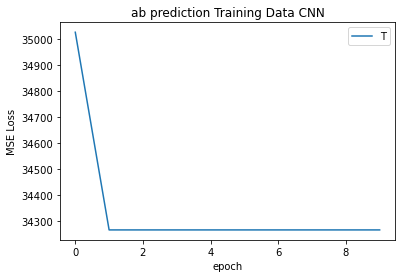

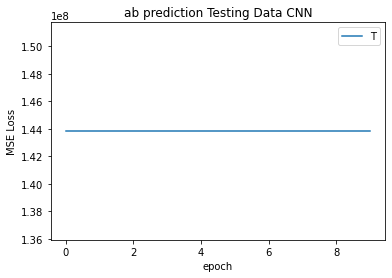

In [55]:


#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device="cpu"
print("Device", device)


batch_size = 10
num_epochs = 10
N=train_size
learning_rate = 0.01
batches = int(N/batch_size)
#batch_size=1

#model = Convnet1()
model = model.float()
model.to(device)

train_data=copy.deepcopy(train_L)
train_data = train_data.to(device)
print("Printing train data shape")
print(train_data.shape)
train_ab = train_ab.to(device)
print("Printing train ab shape")
print(train_ab.shape)
test_data = copy.deepcopy(test_L)
test_data = test_data.to(device)
print("Printing test data shape")
print(test_data.shape)
test_ab = test_ab.to(device)
print("Printing test ab shape")
print(test_ab.shape)


error = nn.MSELoss()  # This works well with the linear output layer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print("batch_size:",batch_size)
print('num_epochs:',num_epochs)
print("learning_rate:",learning_rate)
print("batches:",batches)
print("optimizer:",'Adam')
print("Loss function:","MSELoss")
print(model)

loss_hist = np.zeros(num_epochs)
loss_test_hist = np.zeros(num_epochs)

for epoch in range(num_epochs):
    for index in range(batches):
        patterns = train_data[index*batch_size:(index+1)*batch_size]
        labels = train_ab[index*batch_size:(index+1)*batch_size]
        
        #print("printing all labels shape")
        #print(labels.shape)
        # Forward pass 
        outputs = model(patterns)
        loss = error(outputs, labels)
        

        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()

        #Propagating the error backward
        loss.backward()

        # Optimizing the parameters
        optimizer.step()
        
        #Saving the loss for visualization
        loss_hist[epoch] += loss.data
        

    #test_total
    patterns = test_data
    labels = test_ab
    outputs = model(patterns)
    is_correct = torch.subtract(labels,outputs)
    loss_test_hist[epoch] += (is_correct.sum()*is_correct.sum())/test_size

    if epoch%25==0:
        print("Epoch: {}, Loss: {:.7f}, Testing Loss: {:.3f}".format( 
                        epoch, loss_hist[epoch], loss_test_hist[epoch]))



plt.figure()
plt.plot(loss_hist)
plt.xlabel("epoch")
plt.ylabel("MSE Loss")
plt.title("ab prediction Training Data CNN")
plt.legend("Training Loss")
plt.show()

plt.figure()
plt.plot(loss_test_hist)
plt.xlabel("epoch")
plt.ylabel("MSE Loss")
plt.title("ab prediction Testing Data CNN")
plt.legend("Testing Loss")

plt.show()

In [56]:
torch.save(model, './transfer_learning_colorizer_architecture_1.pkl')

# Transfer Learning Architecture 2

In [88]:
model=torch.load('colorizer.pkl')

In [83]:
for param in model.parameters():
    param.requires_grad=False

In [84]:
model

Convnet(
  (convolution_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
  )
  (deconvolution_layers): Sequential(
    (0): C

In [85]:
model.deconvolution_layers[3]=Sequential(Conv2d(64, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
           BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
           ReLU(),
          Conv2d(60, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
           BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
           ReLU(),
          Conv2d(50, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
           BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
           ReLU(),
          Conv2d(40, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        )

In [86]:
model

Convnet(
  (convolution_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
  )
  (deconvolution_layers): Sequential(
    (0): C

# Fine tuning using Transfer Learning Architecture 2

Device cpu
Printing train data shape
torch.Size([648, 1, 128, 128])
Printing train ab shape
torch.Size([648, 2, 128, 128])
Printing test data shape
torch.Size([73, 1, 128, 128])
Printing test ab shape
torch.Size([73, 2, 128, 128])
batch_size: 10
num_epochs: 10
learning_rate: 0.01
batches: 64
optimizer: Adam
Loss function: MSELoss
Convnet(
  (convolution_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Ba

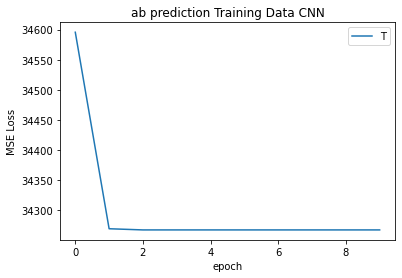

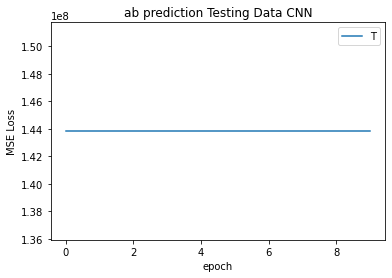

In [87]:


#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device="cpu"
print("Device", device)


batch_size = 10
num_epochs = 10
N=train_size
learning_rate = 0.01
batches = int(N/batch_size)
#batch_size=1

#model = Convnet1()
model = model.float()
model.to(device)

train_data=copy.deepcopy(train_L)
train_data = train_data.to(device)
print("Printing train data shape")
print(train_data.shape)
train_ab = train_ab.to(device)
print("Printing train ab shape")
print(train_ab.shape)
test_data = copy.deepcopy(test_L)
test_data = test_data.to(device)
print("Printing test data shape")
print(test_data.shape)
test_ab = test_ab.to(device)
print("Printing test ab shape")
print(test_ab.shape)


error = nn.MSELoss()  # This works well with the linear output layer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print("batch_size:",batch_size)
print('num_epochs:',num_epochs)
print("learning_rate:",learning_rate)
print("batches:",batches)
print("optimizer:",'Adam')
print("Loss function:","MSELoss")
print(model)

loss_hist = np.zeros(num_epochs)
loss_test_hist = np.zeros(num_epochs)

for epoch in range(num_epochs):
    for index in range(batches):
        patterns = train_data[index*batch_size:(index+1)*batch_size]
        labels = train_ab[index*batch_size:(index+1)*batch_size]
        
        #print("printing all labels shape")
        #print(labels.shape)
        # Forward pass 
        outputs = model(patterns)
        loss = error(outputs, labels)
        

        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()

        #Propagating the error backward
        loss.backward()

        # Optimizing the parameters
        optimizer.step()
        
        #Saving the loss for visualization
        loss_hist[epoch] += loss.data
        

    #test_total
    patterns = test_data
    labels = test_ab
    outputs = model(patterns)
    is_correct = torch.subtract(labels,outputs)
    loss_test_hist[epoch] += (is_correct.sum()*is_correct.sum())/test_size

    if epoch%25==0:
        print("Epoch: {}, Loss: {:.7f}, Testing Loss: {:.3f}".format( 
                        epoch, loss_hist[epoch], loss_test_hist[epoch]))



plt.figure()
plt.plot(loss_hist)
plt.xlabel("epoch")
plt.ylabel("MSE Loss")
plt.title("ab prediction Training Data CNN")
plt.legend("Training Loss")
plt.show()

plt.figure()
plt.plot(loss_test_hist)
plt.xlabel("epoch")
plt.ylabel("MSE Loss")
plt.title("ab prediction Testing Data CNN")
plt.legend("Testing Loss")

plt.show()

Device cpu
Printing train data shape
torch.Size([648, 1, 128, 128])
Printing train ab shape
torch.Size([648, 2, 128, 128])
Printing test data shape
torch.Size([73, 1, 128, 128])
Printing test ab shape
torch.Size([73, 2, 128, 128])
batch_size: 10
num_epochs: 100
learning_rate: 0.01
batches: 64
optimizer: Adam
Loss function: MSELoss
Convnet(
  (convolution_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): B

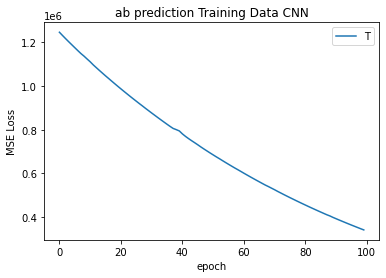

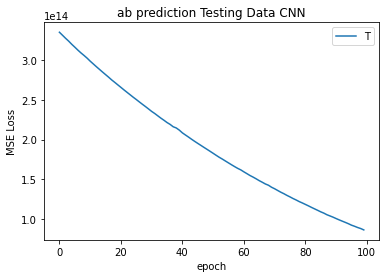

In [97]:


#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device="cpu"
print("Device", device)


batch_size = 10
num_epochs = 100
N=train_size
learning_rate = 0.01
batches = int(N/batch_size)
#batch_size=1

#model = Convnet1()
model=torch.load('transfer_learning_colorizer_architecture_2.pkl')
model.to(device)

train_data=copy.deepcopy(train_L)
train_data = train_data.to(device)
print("Printing train data shape")
print(train_data.shape)
train_ab = train_ab.to(device)
print("Printing train ab shape")
print(train_ab.shape)
test_data = copy.deepcopy(test_L)
test_data = test_data.to(device)
print("Printing test data shape")
print(test_data.shape)
test_ab = test_ab.to(device)
print("Printing test ab shape")
print(test_ab.shape)


error = nn.MSELoss()  # This works well with the linear output layer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print("batch_size:",batch_size)
print('num_epochs:',num_epochs)
print("learning_rate:",learning_rate)
print("batches:",batches)
print("optimizer:",'Adam')
print("Loss function:","MSELoss")
print(model)

loss_hist = np.zeros(num_epochs)
loss_test_hist = np.zeros(num_epochs)

for epoch in range(num_epochs):
    for index in range(batches):
        patterns = train_data[index*batch_size:(index+1)*batch_size]
        labels = train_ab[index*batch_size:(index+1)*batch_size]
        
        #print("printing all labels shape")
        #print(labels.shape)
        # Forward pass 
        outputs = model(patterns)
        loss = error(outputs, labels)
        

        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()

        #Propagating the error backward
        loss.backward()

        # Optimizing the parameters
        optimizer.step()
        
        #Saving the loss for visualization
        loss_hist[epoch] += loss.data
        

    #test_total
    patterns = test_data
    labels = test_ab
    outputs = model(patterns)
    is_correct = torch.subtract(labels,outputs)
    loss_test_hist[epoch] += (is_correct.sum()*is_correct.sum())/test_size

    if epoch%25==0:
        print("Epoch: {}, Loss: {:.7f}, Testing Loss: {:.3f}".format( 
                        epoch, loss_hist[epoch], loss_test_hist[epoch]))



plt.figure()
plt.plot(loss_hist)
plt.xlabel("epoch")
plt.ylabel("MSE Loss")
plt.title("ab prediction Training Data CNN")
plt.legend("Training Loss")
plt.show()

plt.figure()
plt.plot(loss_test_hist)
plt.xlabel("epoch")
plt.ylabel("MSE Loss")
plt.title("ab prediction Testing Data CNN")
plt.legend("Testing Loss")

plt.show()

Device cpu
Printing train data shape
torch.Size([648, 1, 128, 128])
Printing train ab shape
torch.Size([648, 2, 128, 128])
Printing test data shape
torch.Size([73, 1, 128, 128])
Printing test ab shape
torch.Size([73, 2, 128, 128])
batch_size: 10
num_epochs: 300
learning_rate: 0.01
batches: 64
optimizer: Adam
Loss function: MSELoss
Convnet(
  (convolution_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): B

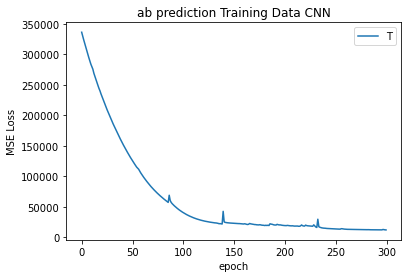

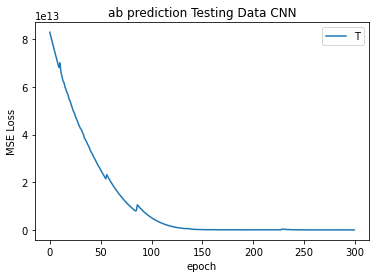

In [8]:


#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device="cpu"
print("Device", device)


batch_size = 10
num_epochs = 300
N=train_size
learning_rate = 0.01
batches = int(N/batch_size)
#batch_size=1

#model = Convnet1()
model=torch.load('transfer_learning_colorizer_architecture2.pkl')
model.to(device)

train_data=copy.deepcopy(train_L)
train_data = train_data.to(device)
print("Printing train data shape")
print(train_data.shape)
train_ab = train_ab.to(device)
print("Printing train ab shape")
print(train_ab.shape)
test_data = copy.deepcopy(test_L)
test_data = test_data.to(device)
print("Printing test data shape")
print(test_data.shape)
test_ab = test_ab.to(device)
print("Printing test ab shape")
print(test_ab.shape)


error = nn.MSELoss()  # This works well with the linear output layer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print("batch_size:",batch_size)
print('num_epochs:',num_epochs)
print("learning_rate:",learning_rate)
print("batches:",batches)
print("optimizer:",'Adam')
print("Loss function:","MSELoss")
print(model)

loss_hist = np.zeros(num_epochs)
loss_test_hist = np.zeros(num_epochs)

for epoch in range(num_epochs):
    for index in range(batches):
        patterns = train_data[index*batch_size:(index+1)*batch_size]
        labels = train_ab[index*batch_size:(index+1)*batch_size]
        
        #print("printing all labels shape")
        #print(labels.shape)
        # Forward pass 
        outputs = model(patterns)
        loss = error(outputs, labels)
        

        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()

        #Propagating the error backward
        loss.backward()

        # Optimizing the parameters
        optimizer.step()
        
        #Saving the loss for visualization
        loss_hist[epoch] += loss.data
        

    #test_total
    patterns = test_data
    labels = test_ab
    outputs = model(patterns)
    is_correct = torch.subtract(labels,outputs)
    loss_test_hist[epoch] += (is_correct.sum()*is_correct.sum())/test_size

    if epoch%25==0:
        print("Epoch: {}, Loss: {:.7f}, Testing Loss: {:.3f}".format( 
                        epoch, loss_hist[epoch], loss_test_hist[epoch]))



plt.figure()
plt.plot(loss_hist)
plt.xlabel("epoch")
plt.ylabel("MSE Loss")
plt.title("ab prediction Training Data CNN")
plt.legend("Training Loss")
plt.show()

plt.figure()
plt.plot(loss_test_hist)
plt.xlabel("epoch")
plt.ylabel("MSE Loss")
plt.title("ab prediction Testing Data CNN")
plt.legend("Testing Loss")

plt.show()

In [9]:
torch.save(model, './transfer_learning_colorizer_architecture_2.pkl')

Device cpu
Printing train data shape
torch.Size([648, 1, 128, 128])
Printing train ab shape
torch.Size([648, 2, 128, 128])
Printing test data shape
torch.Size([73, 1, 128, 128])
Printing test ab shape
torch.Size([73, 2, 128, 128])
batch_size: 10
num_epochs: 150
learning_rate: 0.01
batches: 64
optimizer: Adam
Loss function: MSELoss
Convnet(
  (convolution_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): B

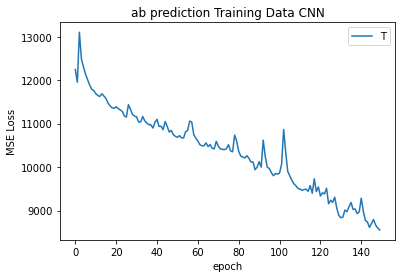

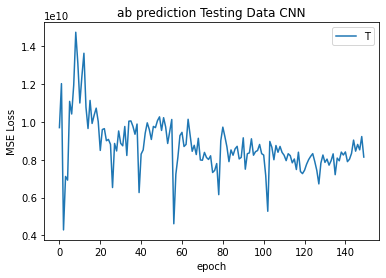

In [10]:


#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device="cpu"
print("Device", device)


batch_size = 10
num_epochs = 150
N=train_size
learning_rate = 0.01
batches = int(N/batch_size)
#batch_size=1

#model = Convnet1()
model=torch.load('transfer_learning_colorizer_architecture_2.pkl')
model.to(device)

train_data=copy.deepcopy(train_L)
train_data = train_data.to(device)
print("Printing train data shape")
print(train_data.shape)
train_ab = train_ab.to(device)
print("Printing train ab shape")
print(train_ab.shape)
test_data = copy.deepcopy(test_L)
test_data = test_data.to(device)
print("Printing test data shape")
print(test_data.shape)
test_ab = test_ab.to(device)
print("Printing test ab shape")
print(test_ab.shape)


error = nn.MSELoss()  # This works well with the linear output layer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print("batch_size:",batch_size)
print('num_epochs:',num_epochs)
print("learning_rate:",learning_rate)
print("batches:",batches)
print("optimizer:",'Adam')
print("Loss function:","MSELoss")
print(model)

loss_hist = np.zeros(num_epochs)
loss_test_hist = np.zeros(num_epochs)

for epoch in range(num_epochs):
    for index in range(batches):
        patterns = train_data[index*batch_size:(index+1)*batch_size]
        labels = train_ab[index*batch_size:(index+1)*batch_size]
        
        #print("printing all labels shape")
        #print(labels.shape)
        # Forward pass 
        outputs = model(patterns)
        loss = error(outputs, labels)
        

        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()

        #Propagating the error backward
        loss.backward()

        # Optimizing the parameters
        optimizer.step()
        
        #Saving the loss for visualization
        loss_hist[epoch] += loss.data
        

    #test_total
    patterns = test_data
    labels = test_ab
    outputs = model(patterns)
    is_correct = torch.subtract(labels,outputs)
    loss_test_hist[epoch] += (is_correct.sum()*is_correct.sum())/test_size

    if epoch%25==0:
        print("Epoch: {}, Loss: {:.7f}, Testing Loss: {:.3f}".format( 
                        epoch, loss_hist[epoch], loss_test_hist[epoch]))



plt.figure()
plt.plot(loss_hist)
plt.xlabel("epoch")
plt.ylabel("MSE Loss")
plt.title("ab prediction Training Data CNN")
plt.legend("Training Loss")
plt.show()

plt.figure()
plt.plot(loss_test_hist)
plt.xlabel("epoch")
plt.ylabel("MSE Loss")
plt.title("ab prediction Testing Data CNN")
plt.legend("Testing Loss")

plt.show()

In [11]:
torch.save(model, './transfer_learning_colorizer_architecture_2.pkl')

In [12]:
torch.save(model, './transfer_learning_colorizer_architecture_2.pkl')

# Colorizing the images using best model achieved

In [29]:
model=torch.load('transfer_learning_colorizer_architecture_2.pkl')
model=model.to("cpu")
for file in os.listdir('./Colorful'):
    if path.exists('./colorized_images_fruits_vegetables') == False:
        os.mkdir('./colorized_images_fruits_vegetables')

    img=cv2.imread('./Colorful/{}'.format(file))
    #print(img)
    c=cv2.resize(img,(128,128))
    L, a, b = cv2.split(c)
    L=np.array(L,dtype=np.float32)
    L=L[np.newaxis,:,:]
    a=np.array(a,dtype=np.float32)
    b=np.array(b,dtype=np.float32)
    ab=[]
    ab.append(a)
    ab.append(b)
    ab=np.array(ab)
    L=torch.tensor(L)
    ab=torch.tensor(ab)
    test_image_L=L
    test_image_L=torch.unsqueeze(test_image_L,dim=0)
    test_image_ab=model(test_image_L)
    #print(test_image_ab.shape)
    #test_image_ab*=1.35
    f=torch.stack((test_image_L[0][0],test_image_ab[0][0],test_image_ab[0][1]),dim=0).clone().detach()
    p=np.array(f)
    data = np.moveaxis(p, 0, 2)
    img = data.astype(np.uint8)
    img=cv2.cvtColor(img,cv2.COLOR_LAB2RGB)
    plt.imsave('./colorized_images_fruits_vegetables/colorized{}'.format(file),img)

In [30]:
model=torch.load('transfer_learning_colorizer_architecture_1.pkl')
model=model.to("cpu")
for file in os.listdir('./Colorful'):
    if path.exists('./colorized_images_fruits_vegetables_v2') == False:
        os.mkdir('./colorized_images_fruits_vegetables_v2')

    img=cv2.imread('./Colorful/{}'.format(file))
    #print(img)
    c=cv2.resize(img,(128,128))
    L, a, b = cv2.split(c)
    L=np.array(L,dtype=np.float32)
    L=L[np.newaxis,:,:]
    a=np.array(a,dtype=np.float32)
    b=np.array(b,dtype=np.float32)
    ab=[]
    ab.append(a)
    ab.append(b)
    ab=np.array(ab)
    L=torch.tensor(L)
    ab=torch.tensor(ab)
    test_image_L=L
    test_image_L=torch.unsqueeze(test_image_L,dim=0)
    test_image_ab=model(test_image_L)
    #print(test_image_ab.shape)
    #test_image_ab*=1.35
    f=torch.stack((test_image_L[0][0],test_image_ab[0][0],test_image_ab[0][1]),dim=0).clone().detach()
    p=np.array(f)
    data = np.moveaxis(p, 0, 2)
    img = data.astype(np.uint8)
    img=cv2.cvtColor(img,cv2.COLOR_LAB2RGB)
    plt.imsave('./colorized_images_fruits_vegetables_v2/colorized{}'.format(file),img)

# Evaluation metrics

In [37]:
def PSNR(original, colorized):
    mse = np.mean((original - colorized) ** 2)
    if(mse == 0):
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr
  
def calc_PSNR(image1,image2):
    original = cv2.imread(image1)
    original = cv2.resize(original,(128,128))
    colorized = cv2.imread(image2)
    value = PSNR(original, colorized)
    return value

def calc_SSIM(image1,image2):
    image1=cv2.imread(image1)
    image1 = cv2.resize(image1,(128,128))
    image2=cv2.imread(image2)
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    (score, diff) = structural_similarity(gray1, gray2, full=True)
    return score

In [38]:
total_psnr=0
count=0
total_ssim=0
#image number is stored in all_indices list
for file in os.listdir('./Colorful/'):
    count+=1
    image1='./Colorful/{}'.format(file)
    image2='./colorized_images_fruits_vegetables/colorized{}'.format(file)
    total_psnr+=calc_PSNR(image1,image2)
    total_ssim+=calc_SSIM(image1,image2)
average_psnr=total_psnr/count
average_ssim=total_ssim/count
print(f"Average PSNR value is {average_psnr} dB")
print(f"Average SSIM value is {average_ssim}")

Average PSNR value is 29.997109268611794 dB
Average SSIM value is 0.7024259505477167
